## 1. Introduction

### 1.1 Dataset Description

1. `Age` (Numeric): the customer’s age.
2. `Employment Type` (Character): the sector of employment.
3. `GraduateOrNot` (Character): whether the customer is a college graduate.
4. `AnnualIncome` (Numeric): the customer’s yearly income.
5. `FamilyMembers` (Numeric): the number of family members living with the customer.
6. `ChronicDiseases` (Numeric): whether the customer has any chronic conditions.
7. `FrequentFlyer` (Character): whether a customer books frequent tickets.
8. `EverTravelledAbroad` (Character): has the customer ever travelled abroad.
9. `TravelInsurance` (Numeric): whether the customer bought travel insurance.

### 1.2 Importing Packages

In [1]:
# import packages for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_style('darkgrid')
sns.set_palette('deep')
plt.figure(figsize=(9,6))

%matplotlib inline

### 1.3 Importing Raw Data

In [2]:
# download raw data from s3 bucket
# save raw data to /data/raw
raw_data = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/travel_insurance.csv')
raw_data.to_csv('~/Documents/travel_insurance_analysis/data/raw/travel_insurance.csv')

## 2. Understanding the data

### 2.1 Inspection of the data

In [3]:
raw_data.head(5) # output first five rows of the data

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
raw_data.info() # get info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


Data looks clean with no missing values

In [5]:
raw_data.describe() # generate descriptive stats of the data

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


A quick glance at the stats tell us that our flyers are young individuals with the age ranging from 25 to 35.
The average annual income is 930,000


In [6]:
raw_data.shape # get shape of the data

(1987, 9)

### 2.2 Data Manipulation

In [7]:
raw_data['ChronicDiseases'].replace({0:'No', 1:'Yes'}, inplace=True)
raw_data.rename(columns={'Employment Type':'EmploymentType'}, inplace=True)

In [8]:
# we can create bins for the AnnualIncome column, grouping an individual's income into 'Band 1', 'Band 2', or 'Band 3'
# Band 1 - low earners
# Band 2 - average earners
# Band 3 - top earners

max_income = raw_data.AnnualIncome.max()
min_income = raw_data.AnnualIncome.min()
bins = np.linspace(min_income, max_income, 4)

bands = ['Band 1', 'Band 2', 'Band 3']

raw_data['IncomeBands'] = pd.cut(raw_data.AnnualIncome, bins, labels=bands)

In [9]:
bins

array([ 300000.,  800000., 1300000., 1800000.])

In [10]:
raw_data.IncomeBands.value_counts(normalize=True)

Band 1    0.421274
Band 2    0.394945
Band 3    0.183781
Name: IncomeBands, dtype: float64

From our result, we can see that approximately 82% of individuals earn below 130,000 annually.

In [11]:
# we can also create age groups from our dataset for more insights
# individuals with age range between 20-29
# individuals with age range between 30-39

raw_data['AgeGroup'] = np.where(raw_data['Age']<30, '20-29', '30-39')

In [12]:
raw_data.head()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,IncomeBands,AgeGroup
0,31,Government Sector,Yes,400000,6,Yes,No,No,0,Band 1,30-39
1,31,Private Sector/Self Employed,Yes,1250000,7,No,No,No,0,Band 2,30-39
2,34,Private Sector/Self Employed,Yes,500000,4,Yes,No,No,1,Band 1,30-39
3,28,Private Sector/Self Employed,Yes,700000,3,Yes,No,No,0,Band 1,20-29
4,28,Private Sector/Self Employed,Yes,700000,8,Yes,Yes,No,0,Band 1,20-29


In [13]:
raw_data.AgeGroup.value_counts(normalize=True)

20-29    0.565174
30-39    0.434826
Name: AgeGroup, dtype: float64

Individuals between the age range 20-29 make up 56.5% of our data.

In [14]:
raw_data['EmploymentType']=raw_data['EmploymentType'].astype('category')
raw_data['GraduateOrNot']=raw_data['GraduateOrNot'].astype('category')
raw_data['FrequentFlyer']=raw_data['FrequentFlyer'].astype('category')
raw_data['EverTravelledAbroad']=raw_data['EverTravelledAbroad'].astype('category')
raw_data['ChronicDiseases']=raw_data['ChronicDiseases'].astype('category')
raw_data['AgeGroup']=raw_data['AgeGroup'].astype('category')

### 2.3 Statistical Analysis and Correlation

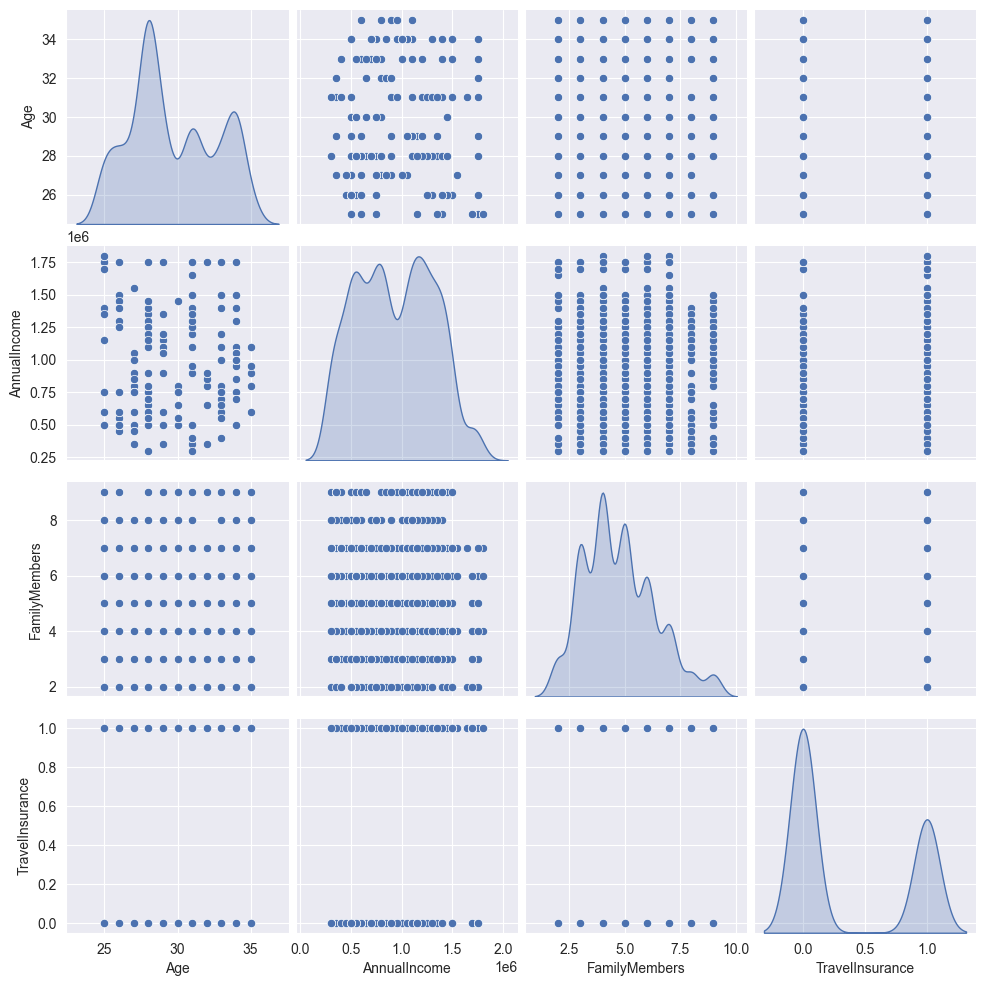

In [15]:
sns.pairplot(raw_data, diag_kind='kde')

Looking at the output of our pairplot, there isn't a clear correlation between the features in our dataset.
To confirm this, we will plot the heatmap of the correlation coefficient.

/var/folders/c0/vh5h_jrn333fnwsjnr_jfdyh0000gn/T/ipykernel_68775/4188213502.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrcoef = raw_data.corr()


<AxesSubplot:>

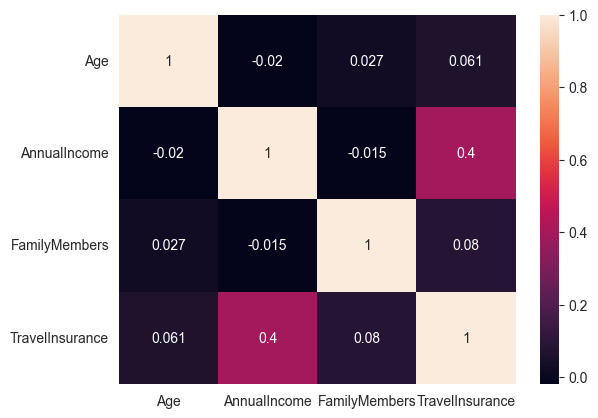

In [16]:
corrcoef = raw_data.corr()
sns.heatmap(corrcoef, annot=True)

We can confirm there is a little to no correlation amongst the features in the dataset. Although, `AnnualIncome` has a weak positive correlation with an individual getting a `TravelInsurance`.

Next, we find correlation between our categorical variables and `TravelInsurance` using the Ordianry Lesat Square method and ANOVA.
Our null hypothesis is that the categorial variables and `TravelInsurance` are not correlated.

In [17]:
cat_cols = raw_data.select_dtypes('category')

anova_list = []

for col in cat_cols:
    model = ols('TravelInsurance' + '~' + col, data=raw_data).fit()
    anova = sm.stats.anova_lm(model, robust='hc3')
    anova_list.append(anova)

pd.concat(anova_list)

,df,sum_sq,mean_sq,F,PR(>F)
EmploymentType,1.0,9.974148,9.974148,44.359162,3.527704e-11
Residual,1985.0,446.326809,0.224850,NaN,NaN
GraduateOrNot,1.0,0.163574,0.163574,0.711834,3.989372e-01
Residual,1985.0,456.137382,0.229792,NaN,NaN
ChronicDiseases,1.0,0.150973,0.150973,0.656978,4.177259e-01
Residual,1985.0,456.149984,0.229798,NaN,NaN
FrequentFlyer,1.0,24.581772,24.581772,113.024434,1.032551e-25
Residual,1985.0,431.719185,0.217491,NaN,NaN
EverTravelledAbroad,1.0,85.623571,85.623571,458.519444,1.088979e-91
Residual,1985.0,370.677385,0.186739,NaN,NaN


From the statistical test above, the features ```GraduateOrNot``` and ```ChronicDiseases``` have p-values greater than 0.05 (0.399, 0.418 respectively). Hence, the null hypothesis is accepted due to p-value not statistically significant.

However, features ```FrequentFlyer```, ```EverTravelledAbroad```, ```EmploymentType```, `AgeGroup` and ```IncomeBands``` have p-values less than 0.05. Hence, the null hypothesis is rejected due to p-value statistically significant. But this does not necessarily mean there is causation.

In [18]:
is_customer = raw_data[raw_data['TravelInsurance']==1]
not_customer = raw_data[raw_data['TravelInsurance']==0]

print("Percentage of travelers that have insurance is {}%.".format(round((len(is_customer) / len(raw_data) * 100), 2)))
print("Percentage of travelers that don't have insurance is {}%.".format(round((len(not_customer) / len(raw_data) * 100), 2)))

Percentage of travelers that have insurance is 35.73%.
Percentage of travelers that don't have insurance is 64.27%.


## 3. Data Visualization

##### Age Distribution

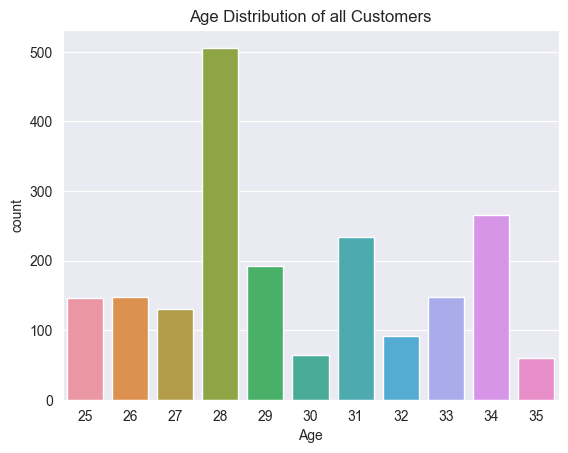

In [19]:
sns.countplot(data=raw_data, x='Age')
plt.title('Age Distribution of all Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/age_1')

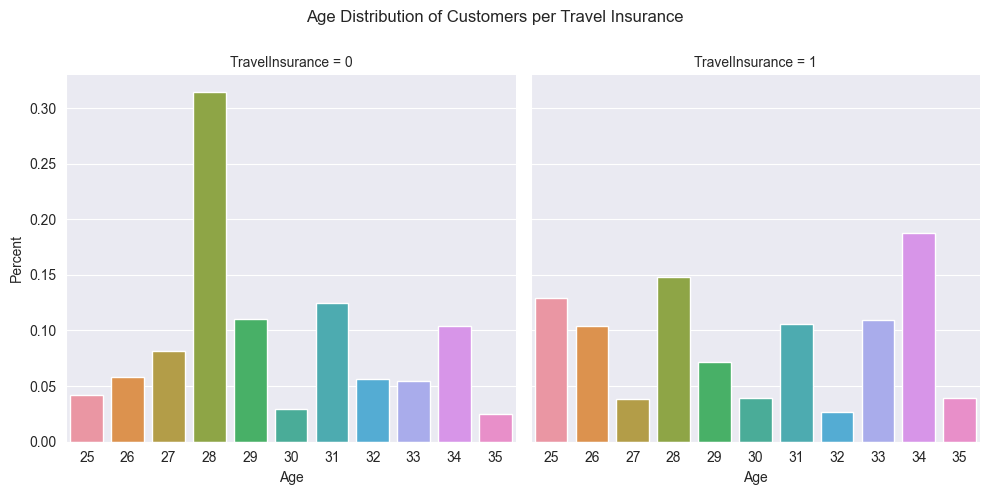

In [20]:
c = (raw_data
.groupby('TravelInsurance')['Age']
.value_counts(normalize=True)
.rename('Percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='Percent', kind='bar', col='TravelInsurance'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle('Age Distribution of Customers per Travel Insurance')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/age_2.png')

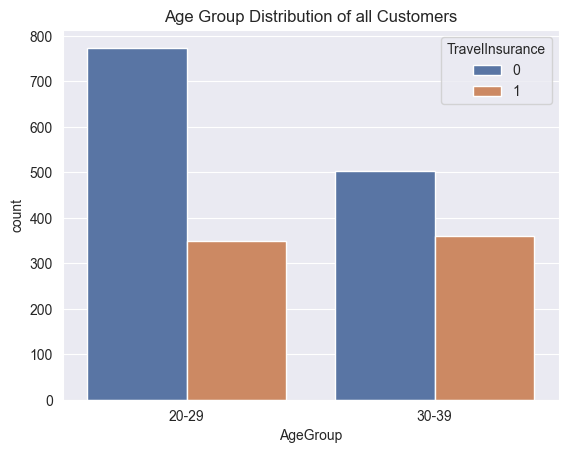

In [21]:
sns.countplot(x = 'AgeGroup', data = raw_data, hue='TravelInsurance')
plt.title('Age Group Distribution of all Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/age_3.png')

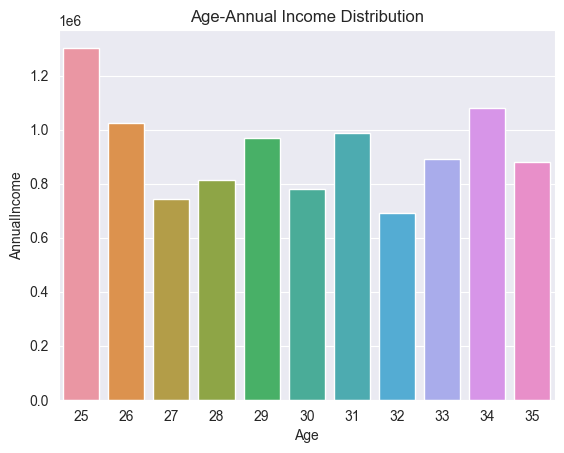

In [22]:
(raw_data
.groupby(['Age'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.barplot, 'data'), x='Age', y='AnnualIncome')
)

plt.title('Age-Annual Income Distribution')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/age_4.png')

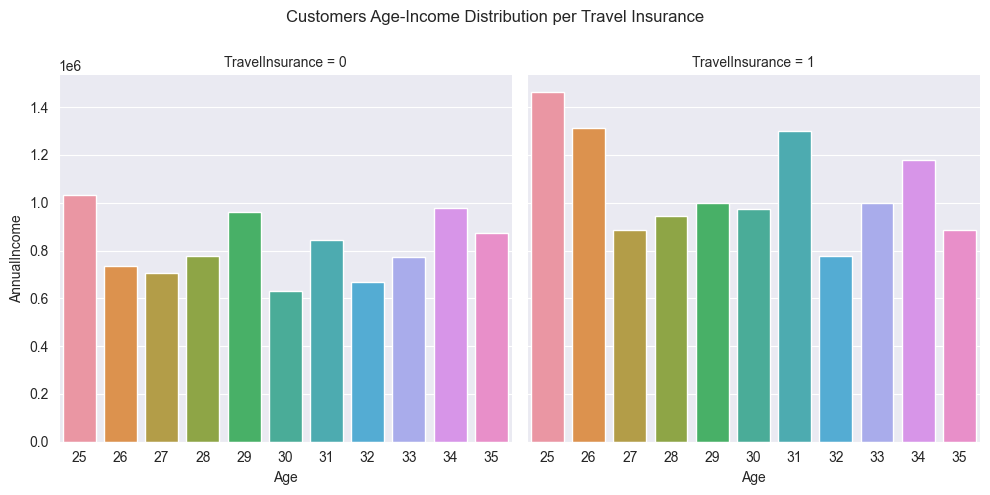

In [23]:
c = (raw_data
.groupby(['Age', 'TravelInsurance'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='TravelInsurance'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle('Customers Age-Income Distribution per Travel Insurance')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/age_5.png')

From the above chart, it can be clearly seen that customers with `TravelInsurance` generally have higher `AnnualIncome` across all `Ages`.

In [24]:
print('The mean annual income of customers with insurance is {}'.format(round(is_customer['AnnualIncome'].mean(), 2)))
print('The mean annual income of customers with no insurance is {}'.format(round(not_customer['AnnualIncome'].mean(), 2)))

The mean annual income of customers with insurance is 1133239.44
The mean annual income of customers with no insurance is 821299.92


##### Family Members

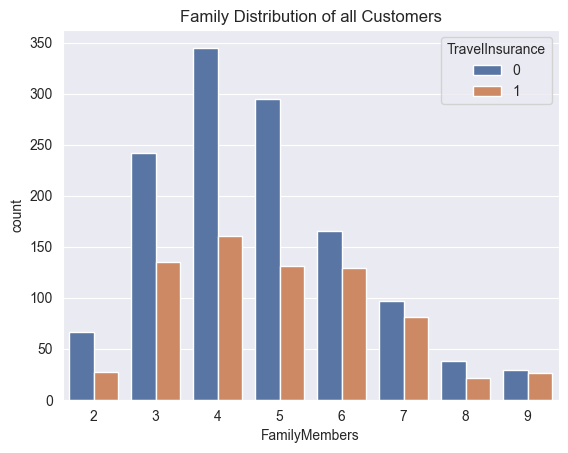

In [25]:
sns.countplot(x = 'FamilyMembers', data = raw_data, hue='TravelInsurance')
plt.title('Family Distribution of all Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/family_1.png')

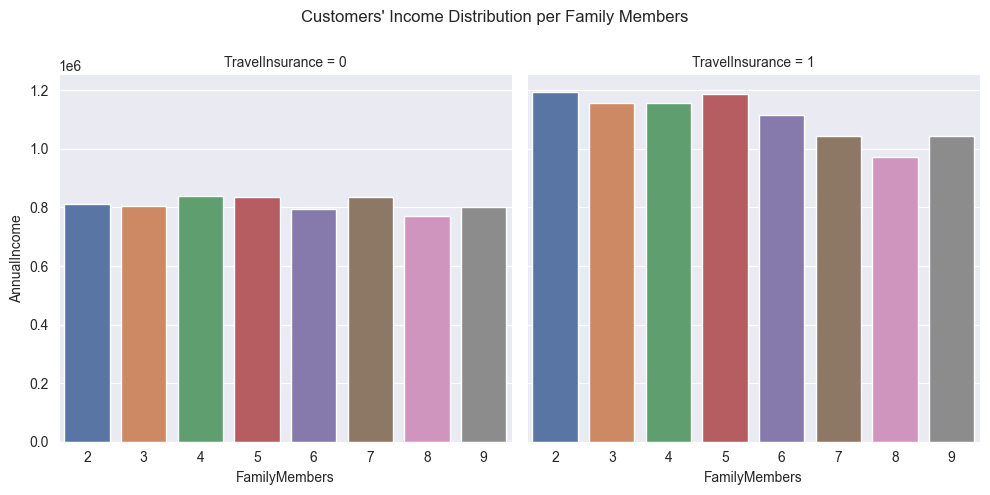

In [26]:
c = (raw_data
.groupby(['FamilyMembers', 'TravelInsurance'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='FamilyMembers', y='AnnualIncome', kind='bar', col='TravelInsurance'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Income Distribution per Family Members")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/family_2.png')

##### Employment Type

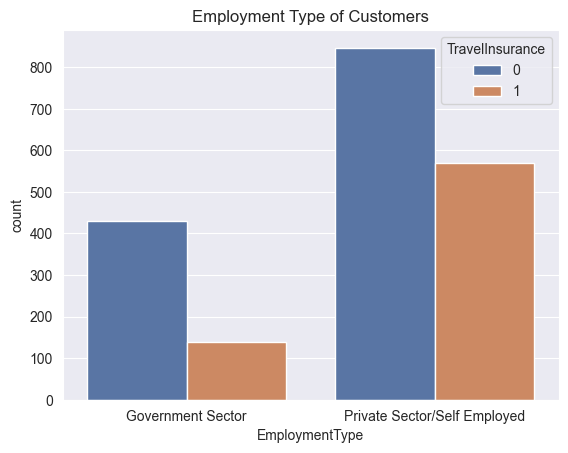

In [27]:
sns.countplot(x = 'EmploymentType', data = raw_data, hue='TravelInsurance')
plt.title('Employment Type of Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/emp_1.png')

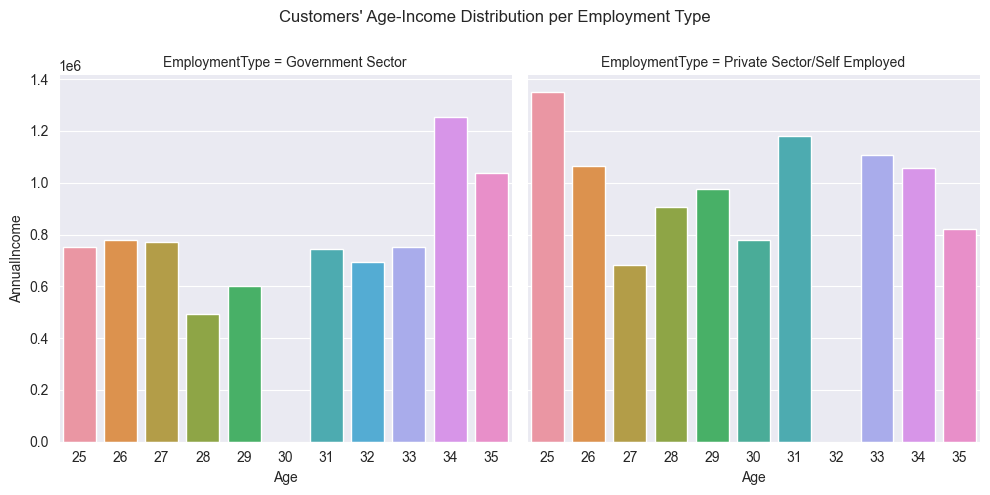

In [28]:
c = (raw_data
.groupby(['Age', 'EmploymentType'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='EmploymentType'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Employment Type")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/emp_2.png')

Customers in the Private Sector or Self Employed tend to have higher annual income than customers in Government Sector.

##### GraduateOrNot

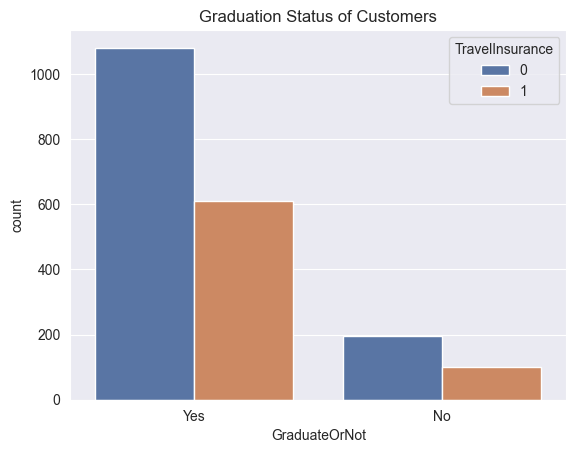

In [29]:
sns.countplot(x = 'GraduateOrNot', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])
plt.title('Graduation Status of Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/grad_1.png')

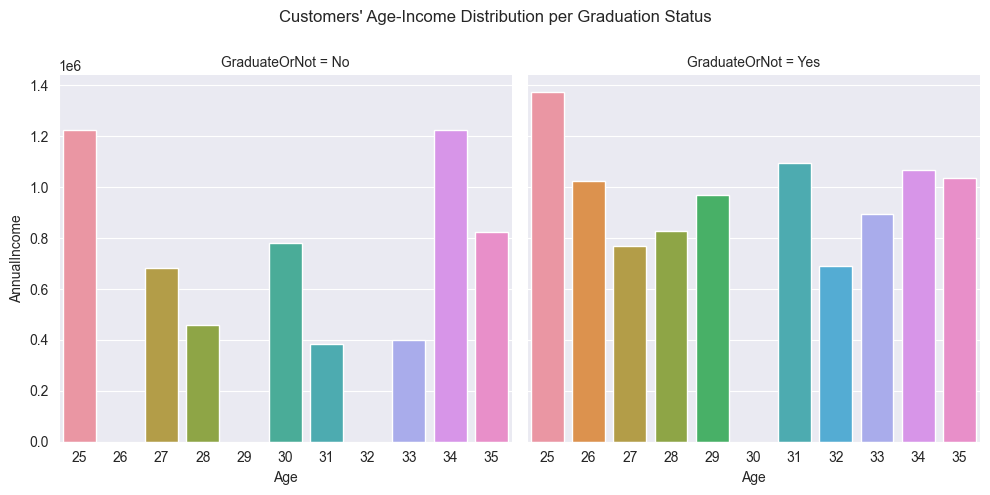

In [30]:
c = (raw_data
.groupby(['Age', 'GraduateOrNot'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='GraduateOrNot'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Graduation Status")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/grad_2.png')

Customers with university degrees tend to have an higher annual income.

##### Chronic Disease

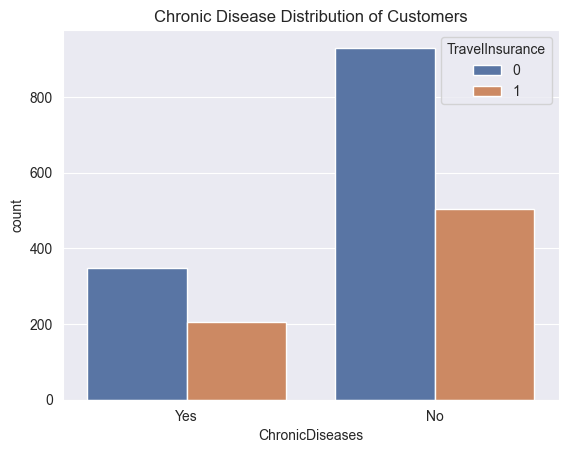

In [31]:
sns.countplot(x = 'ChronicDiseases', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])
plt.title('Chronic Disease Distribution of Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/disease_1.png')

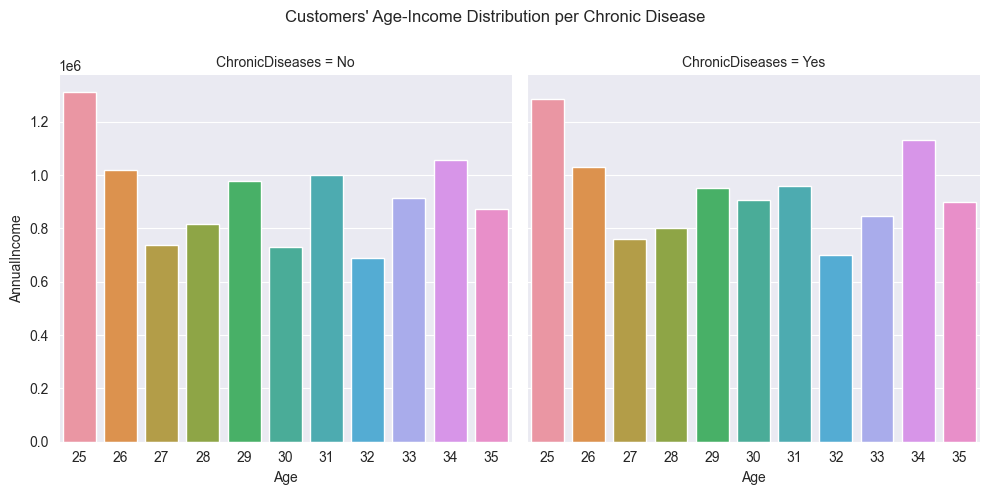

In [32]:
c = (raw_data
.groupby(['Age', 'ChronicDiseases'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='ChronicDiseases'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Chronic Disease")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/disease_2.png')

In the above chart, there isn't much contrast as to the annual income of customers with chronic disease or not.

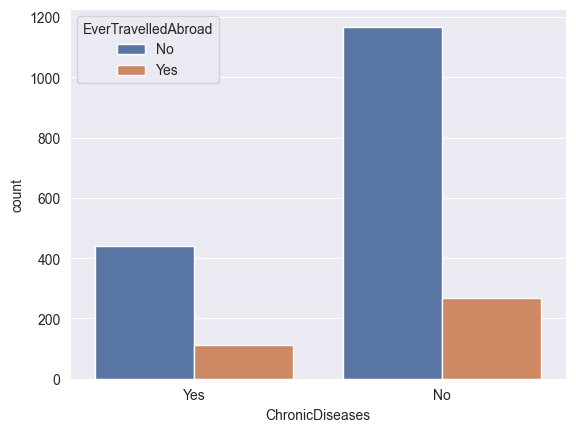

In [33]:
sns.countplot(x = 'ChronicDiseases', data = raw_data, hue='EverTravelledAbroad', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/disease_3.png')

##### Frequent Flyers

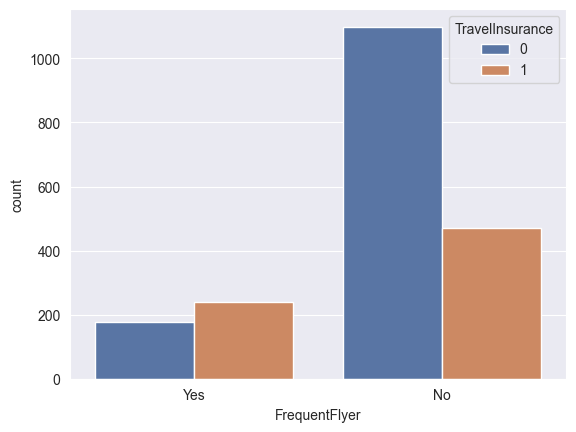

In [34]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/flyer_1.png')

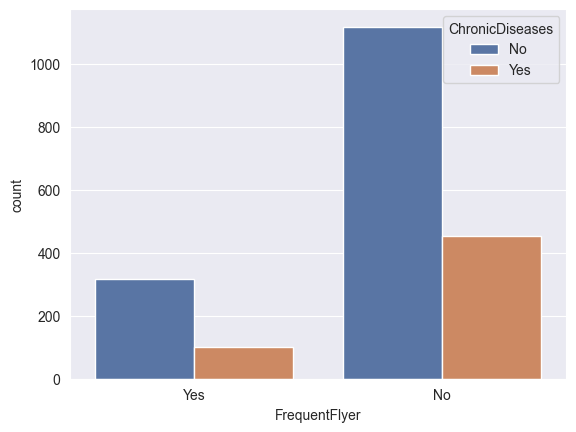

In [35]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='ChronicDiseases', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/flyer_2.png')

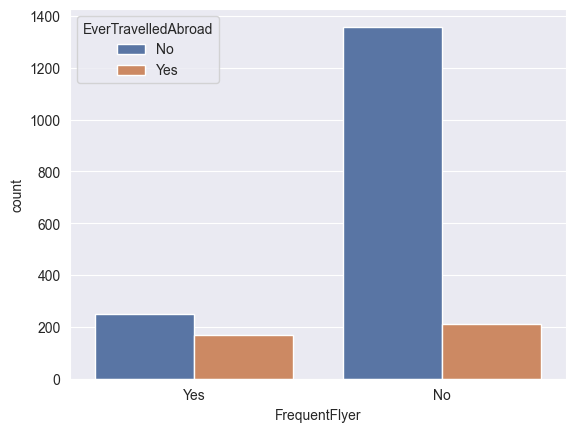

In [36]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='EverTravelledAbroad', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/flyer_3.png')

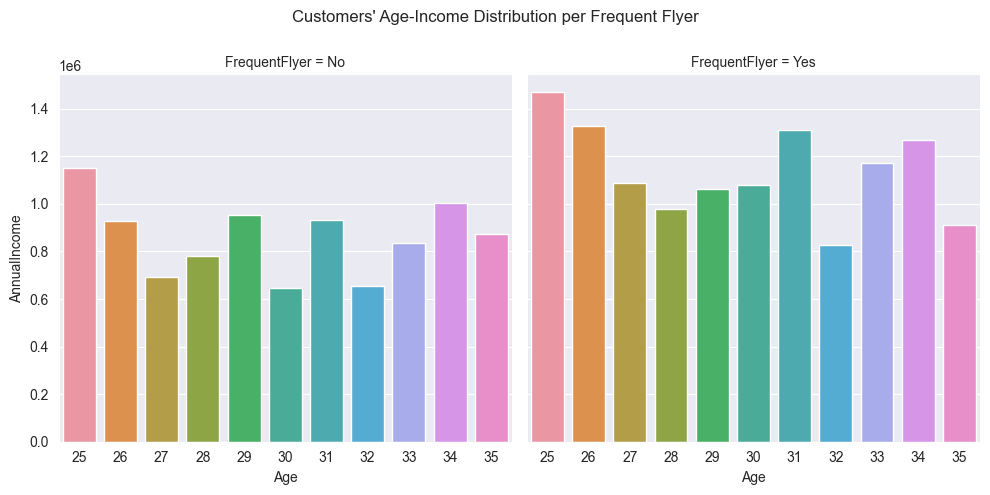

In [37]:
c = (raw_data
.groupby(['Age', 'FrequentFlyer'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='FrequentFlyer'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Frequent Flyer")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/flyer_4.png')

Customers that are Frequent Flyers have higher annual income.

##### Ever Travelled Abroad

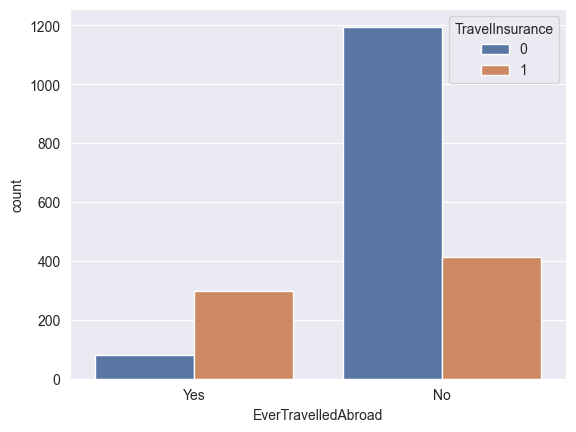

In [38]:
sns.countplot(x = 'EverTravelledAbroad', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/abroad_1.png')

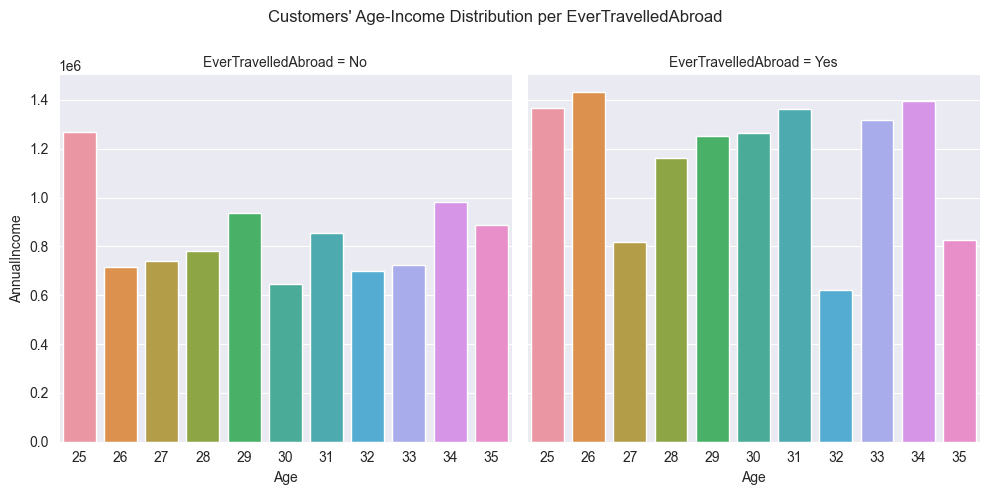

In [39]:
c = (raw_data
.groupby(['Age', 'EverTravelledAbroad'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='EverTravelledAbroad'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per EverTravelledAbroad")
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/abroad_2.png')

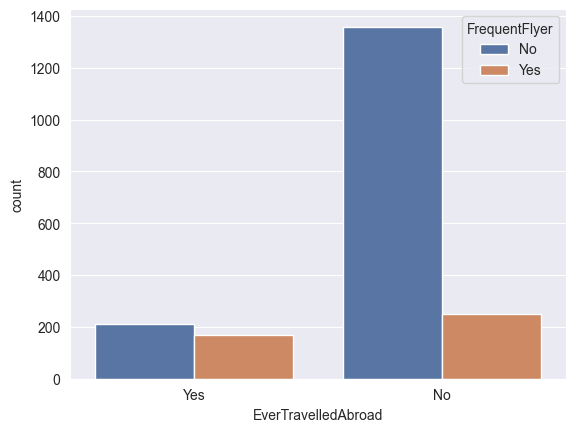

In [40]:
sns.countplot(x = 'EverTravelledAbroad', data = raw_data, hue='FrequentFlyer', order=['Yes', 'No'])
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/abroad_3.png')

##### Annual Income

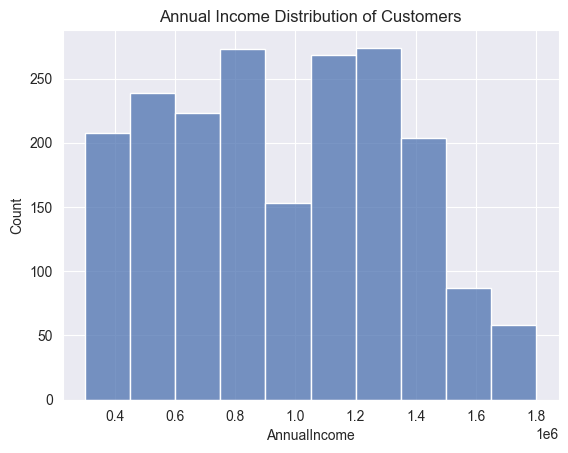

In [41]:
sns.histplot(data=raw_data, x='AnnualIncome', bins=10)
plt.title('Annual Income Distribution of Customers')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/income_1.png')

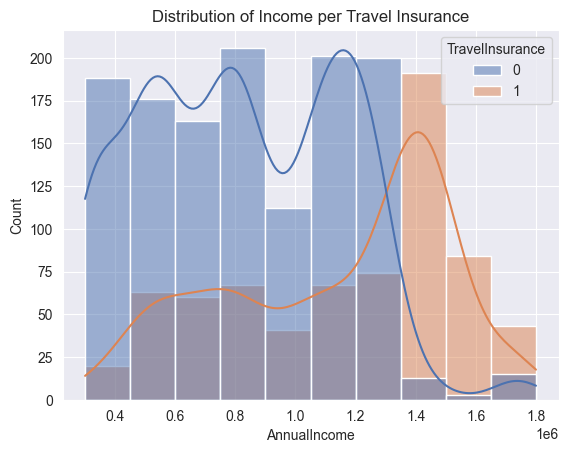

In [42]:
sns.histplot(data=raw_data, x='AnnualIncome', kde=True, hue='TravelInsurance', bins=10)
plt.title('Distribution of Income per Travel Insurance')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/income_2.png')

<AxesSubplot:>

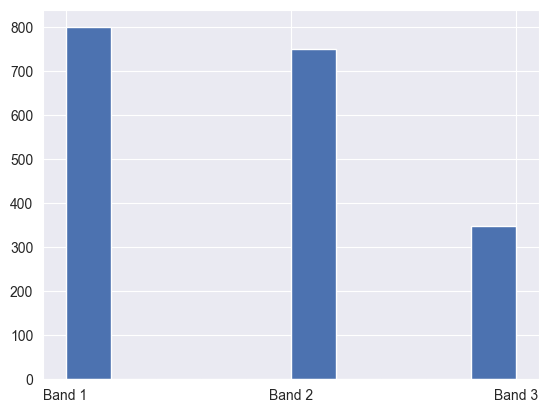

In [43]:
raw_data.IncomeBands.hist()

In [44]:
raw_data.groupby(['TravelInsurance', 'IncomeBands'])['AnnualIncome'].agg({'sum', 'mean'})

sum          mean
TravelInsurance IncomeBands                         
0               Band 1       364100000  5.978654e+05
                Band 2       611450000  1.101712e+06
                Band 3        48650000  1.569355e+06
1               Band 1       119900000  6.277487e+05
                Band 2       216150000  1.108462e+06
                Band 3       466750000  1.467767e+06

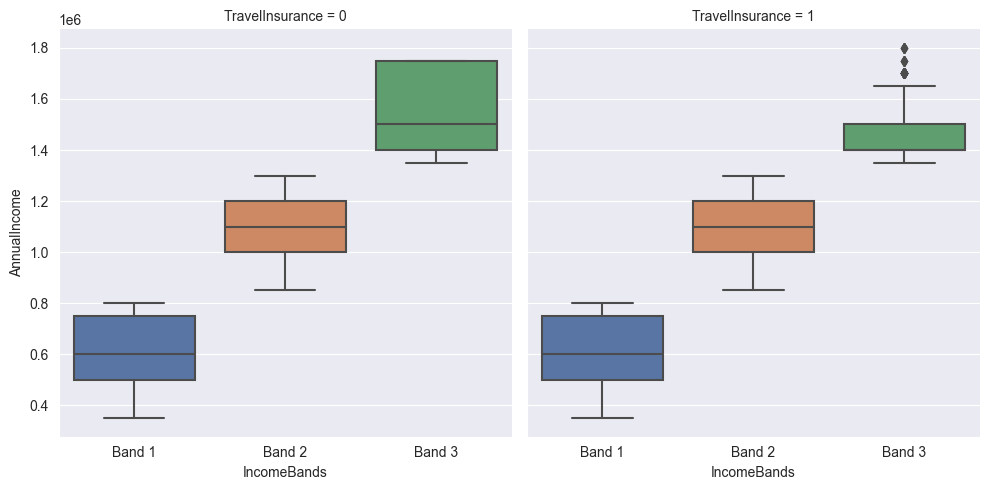

In [45]:
sns.catplot(data=raw_data, x="IncomeBands", y='AnnualIncome', kind='box', col='TravelInsurance')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/income_3.png')

From the above chart, the distribution of AnnualIncome on TravelInsurance is almost equal for all IncomeBands

In [46]:
raw_data.groupby('TravelInsurance')['IncomeBands'].value_counts(normalize=True)

TravelInsurance  IncomeBands
0                Band 1         0.509623
                 Band 2         0.464435
                 Band 3         0.025941
1                Band 3         0.451705
                 Band 2         0.276989
                 Band 1         0.271307
Name: IncomeBands, dtype: float64

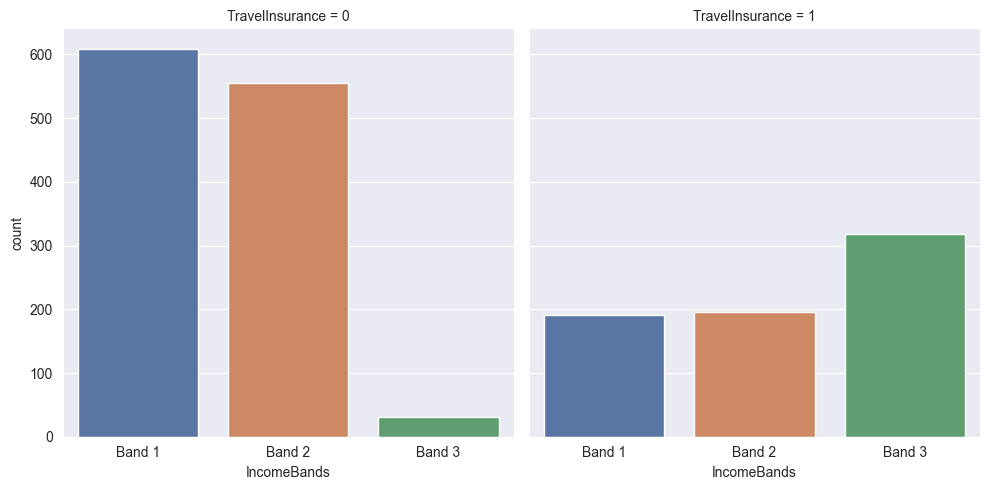

In [47]:
sns.catplot(data=raw_data, x="IncomeBands", kind='count', col='TravelInsurance')
plt.savefig('/Users/ademola/Documents/travel_insurance_analysis/reports/figures/income_4.png')

From the above chart, individuals who have travel insurance can be found more in Income Band 3, accounting to 45% of total individuals with insurance.
However, 2.6% of those without insurance are in Income Band 3. This is intriguing because based on annual income, individual in this band can afford the insurance.
Let's dive more as to why they don't buy travel insurance.

In [48]:
ib3_non_customers = raw_data[(raw_data['IncomeBands']=='Band 3') & (raw_data['TravelInsurance']==0)]
ib3_non_customers.head()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,IncomeBands,AgeGroup
24,31,Government Sector,Yes,1500000,7,No,Yes,Yes,0,Band 3,30-39
35,33,Private Sector/Self Employed,Yes,1400000,4,No,Yes,Yes,0,Band 3,30-39
141,25,Private Sector/Self Employed,Yes,1400000,3,No,No,Yes,0,Band 3,20-29
183,25,Private Sector/Self Employed,No,1700000,3,Yes,Yes,No,0,Band 3,20-29
209,25,Private Sector/Self Employed,No,1700000,3,Yes,Yes,No,0,Band 3,20-29


In [49]:
print(ib3_non_customers.EmploymentType.value_counts(normalize=True), '\n')
print(ib3_non_customers.GraduateOrNot.value_counts(normalize=True), '\n')
print(ib3_non_customers.ChronicDiseases.value_counts(normalize=True), '\n')
print(ib3_non_customers.FrequentFlyer.value_counts(normalize=True), '\n')
print(ib3_non_customers.EverTravelledAbroad.value_counts(normalize=True), '\n')
print(ib3_non_customers.AgeGroup.value_counts(normalize=True), '\n')
print('Mean annual income', round(ib3_non_customers.AnnualIncome.mean(), 2))

Private Sector/Self Employed    0.870968
Government Sector               0.129032
Name: EmploymentType, dtype: float64 

Yes    0.774194
No     0.225806
Name: GraduateOrNot, dtype: float64 

No     0.612903
Yes    0.387097
Name: ChronicDiseases, dtype: float64 

No     0.548387
Yes    0.451613
Name: FrequentFlyer, dtype: float64 

Yes    0.580645
No     0.419355
Name: EverTravelledAbroad, dtype: float64 

30-39    0.516129
20-29    0.483871
Name: AgeGroup, dtype: float64 

Mean annual income 1569354.84


Based on the information above, most individuals in this category (high income and no travel insurance) have no apparent reason not to purchase insurance, as most are graduates working in the private sector or self-employed, with no chronic disease and do travel abroad. This group can be looked into for targeted marketing.

In [50]:
raw_data.TravelInsurance.value_counts(normalize=True)

0    0.642677
1    0.357323
Name: TravelInsurance, dtype: float64

## 4. Modelling

Having done analysis on our dataset, we would be fitting a simple DecisionTreeClassifier model to predict who would get insurance. Due to our dataset being imbalanced (64% no insurance, 36% with insurance), we'll be using `roc_auc_score` as our scoring metric as it is better measure than accuracy.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import roc_auc_score

In [52]:
# convert categorical columns to numeric
cat_cols = raw_data.select_dtypes('category').columns

for col in cat_cols:
    raw_data[col] = raw_data[col].cat.codes

In [53]:
raw_data.head(1)

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,IncomeBands,AgeGroup
0,31,0,1,400000,6,1,0,0,0,0,1


In [54]:
raw_data.to_csv('~/Documents/travel_insurance_analysis/data/processed/clean_travel_insurance.csv')

In [55]:
X = raw_data.drop(columns='TravelInsurance')
y = raw_data.TravelInsurance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [56]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7220030305629414

Our base model tells us it can make predictions on new data with a 72% accuracy. Let's see if we can boost this.

We will be using GridSearchCV to test out several hyperparameters to find the best model.

In [57]:
# Uncomment the following cells to run the grid search

# max_depths = list(range(1, 10))
# min_split = list(range(2,10))
# min_leaf = list(range(1,10))
# criterion = ['gini', 'entropy']

# grid_param = {
#     'max_depth': max_depths,
#     'criterion': criterion,
#     'min_samples_split': min_split,
#     'min_samples_leaf': min_leaf
# }

# gs = GridSearchCV(
#     DecisionTreeClassifier(class_weight='balanced'),
#     grid_param,
#     scoring='roc_auc',
#     return_train_score=True
# )

In [58]:
# gs.fit(X_train, y_train)
# gs.best_params_


In [59]:
# gs.best_score_

In [60]:
# gs_results = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
# gs_results['+/-'] = gs_results['mean_train_score'] - gs_results['mean_test_score']
# gs_results[['param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_train_score', 'mean_test_score', 'rank_test_score', '+/-']].head(50)

From our GridSearch, the best hyperparameters to us is {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6} due to the fact that the difference between mean roc_auc score on the training and test set are not too far apart compared to the top rank score.

In [61]:
best_model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_leaf=3, min_samples_split=6)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7925922749235212

We've been able to increase the accuracy of our model from 72% to 79%. 

In [62]:
feat_importances = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances

,Importance
AnnualIncome,0.684101
FamilyMembers,0.185538
Age,0.113880
GraduateOrNot,0.010397
ChronicDiseases,0.006084
EmploymentType,0.000000
FrequentFlyer,0.000000
EverTravelledAbroad,0.000000
IncomeBands,0.000000
AgeGroup,0.000000


<AxesSubplot:>

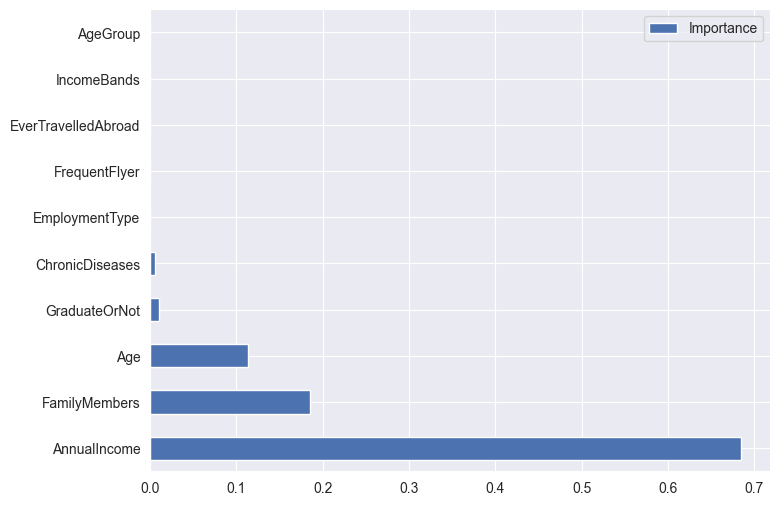

In [63]:
feat_importances.plot(kind='barh', figsize=(8,6))